# Initialization

In [5]:
from Model import *
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from zipfile import ZipFile
import os

#extract data from the zip file

path = "TrainedModels/240embeddings-1encoder-1heads-64tokensize"

with ZipFile(path + ".zip", "r") as myzip:
    myzip.extractall("temp/")

train_metrics = pd.read_csv("temp/train_metrics.csv", index_col=0)
val_metrics = pd.read_csv("temp/val_metrics.csv", index_col = 0)

# Metrics Visualization

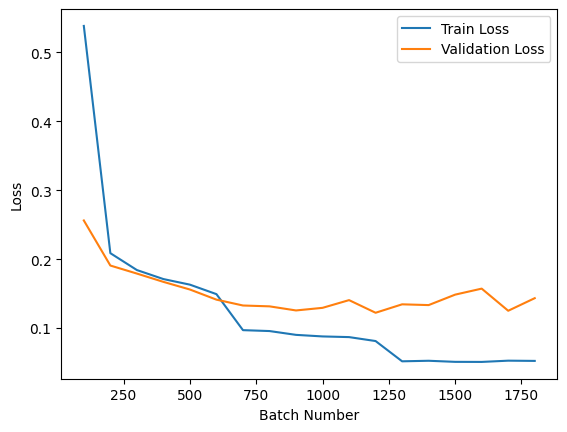

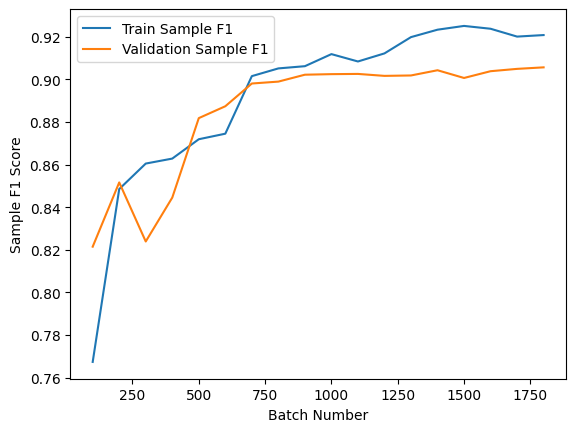

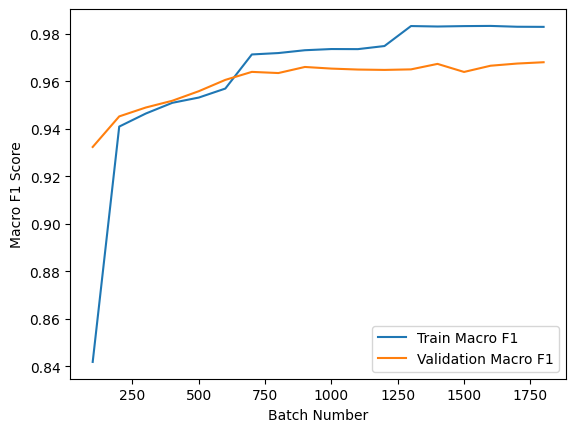

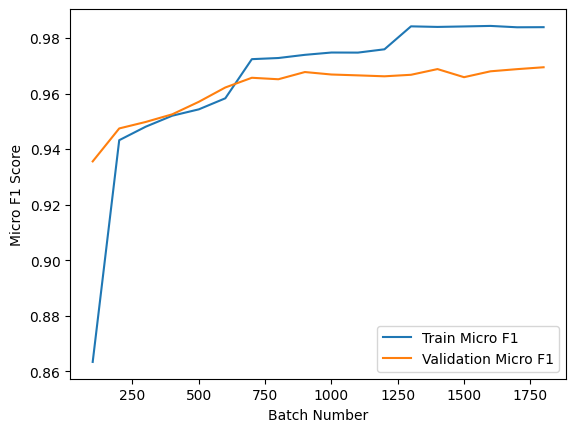

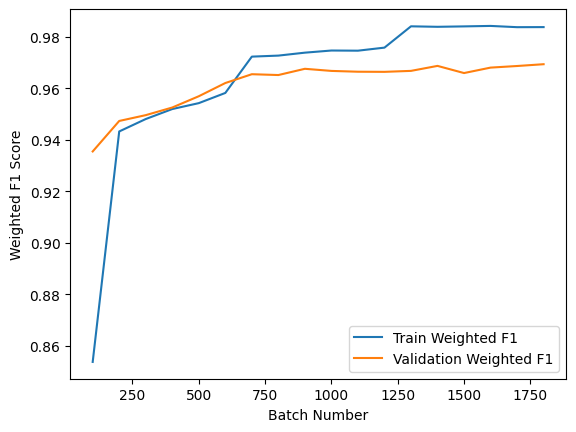

In [6]:
plot_metrics(train_metrics, val_metrics)

# Inference

In [ ]:
#load your data

data_loader = None

#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 240  # embedding dimension
d_hid = 240  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 3  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
threshold = 0.5 # threshold for binary classification

device = "cpu"
model = RandomLM(ntokens, emsize, nhead, d_hid, nlayers, 64, dropout).to(device)
criterion = nn.BCELoss().to(device)
model.load_state_dict(torch.load('model.pt'))

#run inferences on the dataset
model.eval()
test_losses = []
micro_f1s = []
macro_f1s = []
sample_f1s = []
weighted_f1s = []
for i, data in enumerate(data_loader):
    queues, labels = data
    queues = queues.to(device)
    labels = labels.to(device)

    #forward pass
    output = model(queues)
    loss = criterion(output, labels)

    #metrics
    test_losses.append(loss.item())
    micro, macro, sample, weighted = F_score(output, labels, threshold)
    micro_f1s.append(micro)
    macro_f1s.append(macro)
    sample_f1s.append(sample)
    weighted_f1s.append(weighted)

print("Loss: ", np.array(test_losses).mean())
print("Micro F1 Score: ", np.array(micro_f1s).mean())
print("Macro F1 Score: ", np.array(macro_f1s).mean())
print("Sample F1 Score: ", np.array(sample_f1s).mean())
print("Weighted F1 Score: ", np.array(weighted_f1s).mean())

# Ending (must call this cell at the end)

In [9]:
os.remove("temp/train_metrics.csv")
os.remove("temp/val_metrics.csv")
os.remove("temp/model.pt")
os.rmdir("temp")